In [1]:
import pandas as pd
import numpy as np
import os # To set our working folder
import re
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.ticker as mticker
import seaborn as sns
import yfinance as yf  # This gets us prices from Yahoo finance. See https://pypi.org/project/yfinance/
from pandas.tseries.offsets import MonthEnd
import statsmodels.formula.api as smf

---

### Estimating the yield curve from bond yields dowloaded from Datastream and Eikon ###

---

In [2]:
df = pd.read_excel("Search_1653096048350.xlsx")
df=df[['Issuer', 'ISIN', 'Amount Issued (USD)', 'price', 'Coupon', 'Maturity', 'ttm', 'YTM', 'Bond Grade']].dropna()
df.columns = df.columns.str.lower()
df = df.assign(ttm2 = df.ttm**2,
               ttm3 = df.ttm**3
              )

In [5]:
df.sample(5)
#len(df)

,issuer,isin,amount issued (usd),price,coupon,maturity,ttm,ytm,bond grade,ttm2,ttm3
80,Kiwi Property Group Ltd,NZKPGD0050L3,95414991,89.070,2.85,2028-07-19,6.152778,4.9301,Investment Grade,37.856674,232.923705
31,Meridian Energy Ltd,NZMELDT024C2,95414991,101.494,4.88,2024-03-20,1.822222,4.0234,Investment Grade,3.320494,6.050678
22,ANZ Bank New Zealand Ltd,NZANBDT017C1,95414991,99.842,3.71,2023-09-01,1.269444,3.8277,Investment Grade,1.611489,2.045696
23,Kiwi Property Group Ltd,NZKPGD0020L6,79512493,99.908,4.00,2023-09-07,1.286111,4.0622,Investment Grade,1.654082,2.127333
9,Auckland International Airport Ltd,NZAIADT200L2,63609994,100.608,4.28,2022-11-09,0.458333,2.9173,Investment Grade,0.210069,0.096282


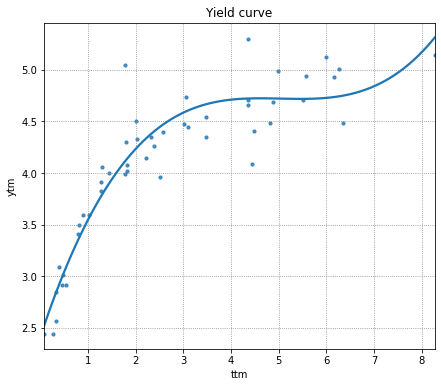

                            OLS Regression Results                            
Dep. Variable:                    ytm   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     104.9
Date:                Tue, 31 May 2022   Prob (F-statistic):           4.50e-20
Time:                        14:42:33   Log-Likelihood:                -3.5724
No. Observations:                  48   AIC:                             15.14
Df Residuals:                      44   BIC:                             22.63
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4119      0.123     19.634      0.0

In [6]:
#Scatter Plot

def set_xmargin(ax, left=0.0, right=0.3):
    ax.set_xmargin(0)
    ax.autoscale_view()
    lim = ax.get_xlim()
    delta = np.diff(lim)
    left =  lim[0] - delta*left
    right = lim[1] + delta*right
    ax.set_xlim(left,right)

def scattplot(X, Y, monthly_ret):
    results = smf.ols('ytm ~ 1 + ttm + ttm2 + ttm3', data=df).fit()
    
    fig = plt.figure(figsize=(7,6))
    ax = sns.regplot(x=X, y=Y, data=df, scatter_kws={"s": 10}, order=3, ci=None)
    
    set_xmargin(ax, left=0, right=0)
    
    # Titles and axes names
    ax.set_title(r'Yield curve')
    ax.set_xlabel(X)
    ax.set_ylabel(Y)
    plt.grid(linestyle="dotted", color='grey')
    
    # Equation
    #plusmin = '-' if results.params.Intercept<0 else '+'
    #equation = f'${{{Y}}}$ =  {results.params[1]:.3f} ${{{X}}}$ {plusmin} {abs(results.params.Intercept):.3f}'
    #ax.text(y = monthly_ret[Y].max(), x = monthly_ret[X].min(), s = equation)
    plt.show()
    print(results.summary())
    return results.params

params  = scattplot("ttm", "ytm", df)

In [ ]:
params

---

### Risk free rate and market premium using RBNZ data and the NZ50 ###

In [7]:
dfr = pd.read_excel("hb2-monthly.xlsx", skiprows=[0,2,3,4])
dfr.sample(5)

,Unnamed: 0,Official Cash Rate (OCR),Overnight interbank cash rate,30 days,60 days,90 days,1 year,2 year,5 year,10 year,15 February 2016,20 September 2025,20 September 2030,20 September 2035,20 September 2040
233,2004-06-30,5.75,5.68,5.93,6.01,6.07,5.93,5.97,6.16,6.29,3.75,NaN,NaN,NaN,NaN
435,2021-04-30,0.25,0.24,0.26,0.30,0.34,NaN,0.25,0.88,1.68,NaN,-1.00,-0.20,0.44,0.94
108,1994-01-31,NaN,4.54,4.60,4.62,4.66,4.79,4.89,5.31,5.69,NaN,NaN,NaN,NaN,NaN
3,1985-04-30,NaN,17.43,20.37,21.16,22.07,NaN,19.00,18.67,17.73,NaN,NaN,NaN,NaN,NaN
373,2016-02-29,2.50,2.37,2.54,2.58,2.62,NaN,2.37,2.61,3.06,1.30,2.03,2.21,2.36,NaN


In [8]:
dfr=dfr[['Unnamed: 0', '90 days', '5 year']].dropna() # https://fealty.co.nz/business-valuation-nz/#:~:text=NZ%20Treasury%20%28October%202016%29%20has%20provided%20a%20risk,risk%20premium%20of%207%25.%20Specific%20Company%20Risk%20Premium
dfr.columns = ['Date', 'rf', 'rf5']
list(dfr)
dfr["Date"]= pd.to_datetime(dfr["Date"])
dfr.set_index('Date', inplace=True)
dfr = dfr.shift(1) # Attribute April data to May, as the date can be taken as ex ante
dfr.dropna(inplace=True)
dfr.tail(5)

,rf,rf5
Date,,
2021-12-31,0.83,2.33
2022-01-31,0.91,2.21
2022-02-28,1.03,2.36
2022-03-31,1.21,2.58
2022-04-30,1.49,2.93


In [9]:
dfr /= 1200

In [10]:
dfr.head()

,rf,rf5
Date,,
1985-04-30,0.022058,0.015342
1985-05-31,0.018392,0.015558
1985-06-30,0.020208,0.016583
1985-07-31,0.019775,0.015150
1985-08-31,0.020017,0.014892


<AxesSubplot:xlabel='Date'>

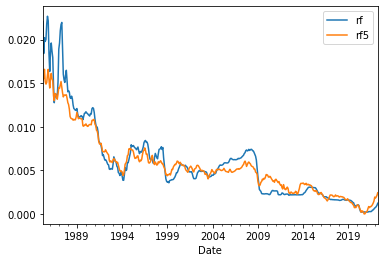

In [11]:
dfr.plot()

In [12]:
dfm = yf.download(tickers=['^NZ50'], start='1985-03-31', end='2022-04-30', interval="1mo")['Adj Close'].dropna().to_frame()
dfm.columns = ['MPrice']
dfm.index = pd.to_datetime(dfm.index, format="%Y%m") + MonthEnd(0)

[*********************100%***********************]  1 of 1 completed


In [13]:
dfm = np.log(dfm).diff().dropna()
dfm = dfm.shift(1) # Attribute April data to May, as the date can be taken as ex ante
dfm.dropna(inplace=True)

<AxesSubplot:xlabel='Date'>

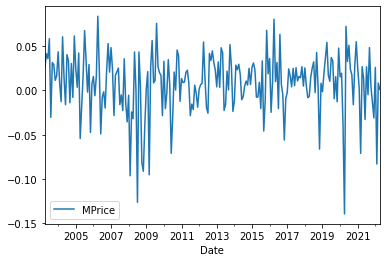

In [14]:
dfm.plot()

**Join market return and risk-free rate**

In [15]:
dfmr = dfm.join(dfr)

<AxesSubplot:xlabel='Date'>

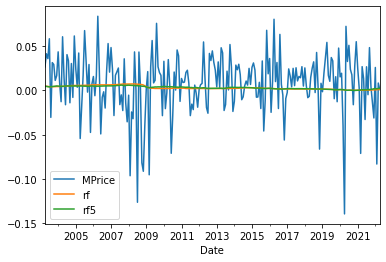

In [16]:
dfmr.plot()

In [17]:
dfmr['Market Risk premium'] = dfmr['MPrice'].sub(dfmr['rf5'])

<AxesSubplot:xlabel='Date'>

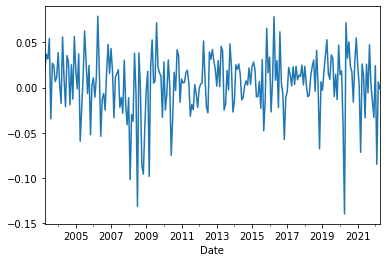

In [18]:
dfmr['Market Risk premium'].plot()

In [19]:
dfmr['Market Risk premium'].mean()*100

0.49286210414783316